In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from utils import train_classifier, plot_images
from datasets import load_nist_data

## MNIST sample 

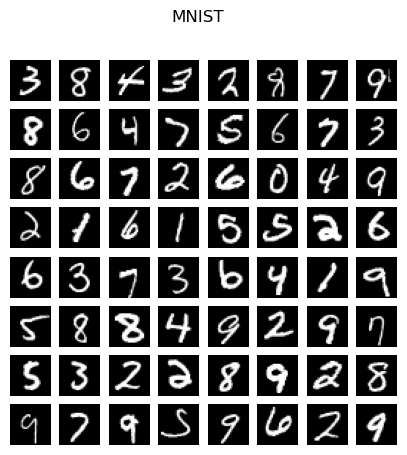

In [2]:
#...Retrieve 100 samples from training sample

data_mnist_reference = load_nist_data(name='MNIST', train=True, binerize=False)
loader_mnist_reference = DataLoader(data_mnist_reference, batch_size=64, shuffle=True)
images_mnist_reference, _ = next(iter(loader_mnist_reference))

plot_images(images_mnist_reference, "MNIST", figsize=(5, 5))

## Perturbed Pepper MNIST 

We first define the reference sample as binarized MNIST (with binarization threshold of 0.5)

We now define the following perturbations of peppered MNIST:
- Pepper MNIST with binarizing thresholds different than 0.5 
- Gaussian noise 
- Gaussian Blurr
- Swirl deformation

We will later compute the FID between these datasets and the reference Pepper MNIST (binerized threshold=0.5) 

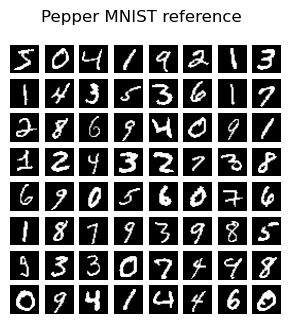

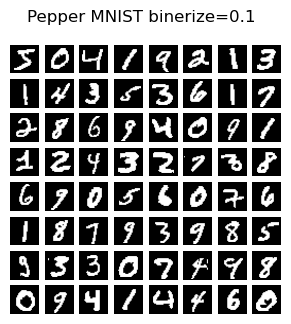

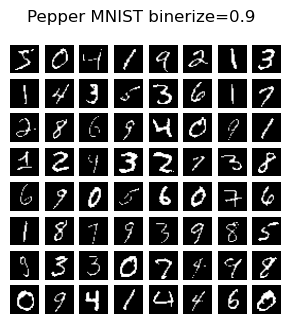

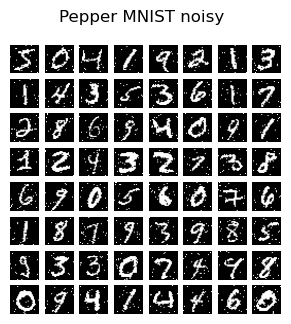

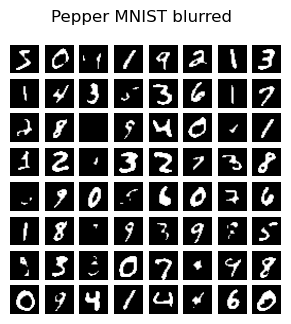

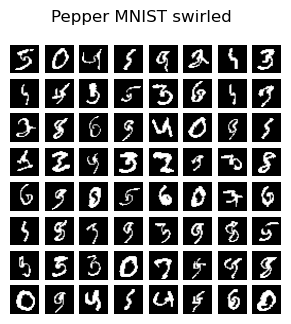

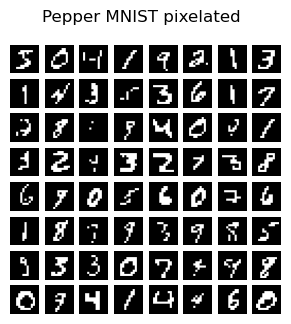

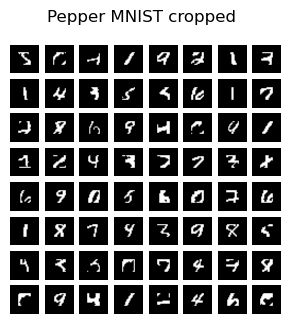

In [7]:
#...Reference dfataset:

data = load_nist_data(name='MNIST', train=True)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Pepper MNIST reference", figsize=(3.5, 3.5))

#...Distorted datasets:

data = load_nist_data(name='MNIST',  train=True, distortion='binerize', level=0.1)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Pepper MNIST binerize=0.1", figsize=(3.5, 3.5))

data = load_nist_data(name='MNIST', train=True, distortion='binerize', level=0.9)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Pepper MNIST binerize=0.9", figsize=(3.5, 3.5))

data = load_nist_data(name='MNIST', train=True, distortion='noise', level=0.25)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Pepper MNIST noisy", figsize=(3.5, 3.5))

data = load_nist_data(name='MNIST', train=True, distortion='blur', level=1.25)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Pepper MNIST blurred", figsize=(3.5, 3.5))

data = load_nist_data(name='MNIST', train=True, distortion='swirl', level=3)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Pepper MNIST swirled", figsize=(3.5, 3.5))

data = load_nist_data(name='MNIST', train=True, distortion='pixelize', level=0.5)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Pepper MNIST pixelated", figsize=(3.5, 3.5))

data = load_nist_data(name='MNIST', train=True, distortion='crop', level=0.55)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Pepper MNIST cropped", figsize=(3.5, 3.5))


##  LeNet-5 classifier for MNIST
We load a pre-trained LeNet-5 classifier and evaluate on the Reference Pepper MNIST data in ordfer to get the mean and std of the features of a specific layer

In [43]:
import torch
from utils import get_model_accuracy
from architectures import LeNet5
from fid import get_layer_features

model = LeNet5()
model.load_state_dict(torch.load('models/model_MNIST_LeNet5.pth'))
model.eval()

#...Load MNIST test dataset

test_data_mnist_ref = load_nist_data(name='MNIST', train=False)

#...compute mean and std of second layer features from reference data:

mu, sigma = get_layer_features(model, test_data_mnist_ref, extract_feature_layer='fc2')
print('mu = {}'.format(mu))
print('sigma = {}'.format(sigma))

model accuracy = 98.54%
mu = tensor([3.5234e+00, 0.0000e+00, 2.0546e+00, 1.9534e+00, 1.8247e+00, 5.9069e-06,
        3.3397e+00, 1.6217e-01, 1.2797e+00, 3.6989e+00, 0.0000e+00, 3.3292e+00,
        8.3208e-01, 2.4682e+00, 2.2877e+00, 2.4450e+00, 1.6819e+00, 0.0000e+00,
        0.0000e+00, 2.6053e+00, 2.9157e+00, 2.1067e+00, 0.0000e+00, 1.1167e+00,
        1.5911e+00, 1.4422e+00, 2.2890e+00, 8.6043e-01, 2.3231e+00, 6.0368e-01,
        1.1739e+00, 2.5338e+00, 1.5529e+00, 0.0000e+00, 1.7286e-01, 1.8327e+00,
        1.4750e+00, 2.4528e+00, 2.1777e+00, 3.5560e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.7982e+00, 2.3353e+00, 4.4892e+00, 2.1124e+00, 3.9103e+00,
        1.1935e+00, 0.0000e+00, 2.2989e+00, 2.5999e+00, 3.2418e+00, 3.2326e+00,
        0.0000e+00, 2.5671e+00, 1.2861e+00, 1.2712e+00, 2.6821e+00, 2.8366e+00,
        2.3046e+00, 3.0304e+00, 2.9021e+00, 2.0441e+00, 0.0000e+00, 0.0000e+00,
        1.1313e+00, 4.0355e+00, 2.2484e+00, 3.9552e+00, 4.1848e+00, 3.9289e+00,
        1.5

We compute the fid for different MNIST distortions:

In [45]:
from fid import compute_fid

data = load_nist_data(name='MNIST',  train=True, distortion='binerize', level=0.1)
fid = compute_fid(model, data, mu, sigma, extract_feature_layer='fc2')
print('binerize (0.1): fid = {}'.format(fid))

data = load_nist_data(name='MNIST', train=True, distortion='binerize', level=0.9)
fid = compute_fid(model, data, mu, sigma, extract_feature_layer='fc2')
print('binerize (0.9): fid = {}'.format(fid))

data = load_nist_data(name='MNIST', train=True, distortion='noise', level=0.25)
fid = compute_fid(model, data, mu, sigma, extract_feature_layer='fc2')
print('gassian noise: fid = {}'.format(fid))

data = load_nist_data(name='MNIST', train=True, distortion='blur', level=1.25)
fid = compute_fid(model, data, mu, sigma, extract_feature_layer='fc2')
print('gaussian blurr: fid = {}'.format(fid))

data = load_nist_data(name='MNIST', train=True, distortion='swirl', level=3)
fid = compute_fid(model, data, mu, sigma, extract_feature_layer='fc2')
print('swirl: fid = {}'.format(fid))

data = load_nist_data(name='MNIST', train=True, distortion='pixelize', level=0.5)
fid = compute_fid(model, data, mu, sigma, extract_feature_layer='fc2')
print('pixalated: fid = {}'.format(fid))

data = load_nist_data(name='MNIST', train=True, distortion='crop', level=0.55)
fid = compute_fid(model, data, mu, sigma, extract_feature_layer='fc2')
print('cropped: fid = {}'.format(fid))

binerize (0.1): fid = 3.204987049102783
binerize (0.9): fid = 33.4655876159668
gassian noise: fid = 10.77590560913086
gaussian blurr: fid = 14.259319305419922
swirl: fid = 74.61888122558594
pixalated: fid = 14.598908424377441
cropped: fid = 137.7592010498047


## FID Experiments

Below we compute the FID metric between the reference MNIST data and various distortion levels.
For the classifier we used the LeNet-5 architecture as above. We show that the FID computed from 
features in the second layer has a better separation power than the featuires extracted from
the first and third layers accross all considered deformation. 

### 1. Binarizing Threshold


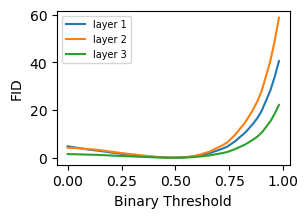

In [34]:
import numpy as np
from fid import distorted_NIST_fid

fid_1 = distorted_NIST_fid(model, name='MNIST', distortion='binerize', values=np.arange(0.0, 1, 0.02), layer='fc1')
fid_2 = distorted_NIST_fid(model, name='MNIST', distortion='binerize', values=np.arange(0.0, 1, 0.02), layer='fc2')
fid_3 = distorted_NIST_fid(model, name='MNIST', distortion='binerize', values=np.arange(0.0, 1, 0.02), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid_1.keys(), fid_1.values(), label='layer 1')
plt.plot(fid_2.keys(), fid_2.values(), label='layer 2')
plt.plot(fid_3.keys(), fid_3.values(), label='layer 3')
plt.ylabel('FID')
plt.xlabel('Binary Threshold')
plt.legend(loc='upper left', fontsize=7)
plt.show()

### 2. Gaussian noise

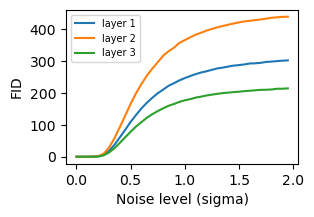

In [40]:
import numpy as np
from fid import distorted_NIST_fid

fid_1 = distorted_NIST_fid(model, name='MNIST', distortion='noise', values=np.arange(0.0, 2, 0.05), layer='fc1')
fid_2 = distorted_NIST_fid(model, name='MNIST', distortion='noise', values=np.arange(0.0, 2, 0.05), layer='fc2')
fid_3 = distorted_NIST_fid(model, name='MNIST', distortion='noise', values=np.arange(0.0, 2, 0.05), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid_1.keys(), fid_1.values(), label='layer 1')
plt.plot(fid_2.keys(), fid_2.values(), label='layer 2')
plt.plot(fid_3.keys(), fid_3.values(), label='layer 3')
plt.ylabel('FID')
plt.xlabel('Noise level (sigma)')
plt.legend(loc='upper left', fontsize=7)
plt.show()

### 3. Gaussian blur

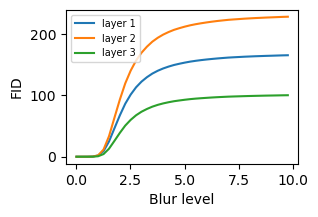

In [35]:
import numpy as np
from fid import distorted_NIST_fid

fid_1 = distorted_NIST_fid(model, name='MNIST', distortion='blur', values=np.arange(0.01, 10, 0.25), layer='fc1')
fid_2 = distorted_NIST_fid(model, name='MNIST', distortion='blur', values=np.arange(0.01, 10, 0.25), layer='fc2')
fid_3 = distorted_NIST_fid(model, name='MNIST', distortion='blur', values=np.arange(0.01, 10, 0.25), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid_1.keys(), fid_1.values(), label='layer 1')
plt.plot(fid_2.keys(), fid_2.values(), label='layer 2')
plt.plot(fid_3.keys(), fid_3.values(), label='layer 3')
plt.ylabel('FID')
plt.xlabel('Blur level')
plt.legend(loc='upper left', fontsize=7)
plt.show()

### 4. Swirl deformation

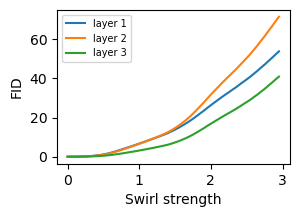

In [36]:
import numpy as np
from fid import distorted_NIST_fid

fid_1 = distorted_NIST_fid(model, name='MNIST', distortion='swirl', values=np.arange(0, 3, 0.05), layer='fc1')
fid_2 = distorted_NIST_fid(model, name='MNIST', distortion='swirl', values=np.arange(0, 3, 0.05), layer='fc2')
fid_3 = distorted_NIST_fid(model, name='MNIST', distortion='swirl', values=np.arange(0, 3, 0.05), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid_1.keys(), fid_1.values(), label='layer 1')
plt.plot(fid_2.keys(), fid_2.values(), label='layer 2')
plt.plot(fid_3.keys(), fid_3.values(), label='layer 3')
plt.ylabel('FID')
plt.xlabel('Swirl strength')
plt.legend(loc='upper left', fontsize=7)
plt.show()

### 5. Pixelization

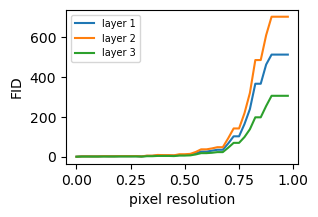

In [38]:
import numpy as np
from fid import distorted_NIST_fid

fid_1 = distorted_NIST_fid(model, name='MNIST', distortion='pixelize', values=np.arange(0, 1, 0.025), layer='fc1')
fid_2 = distorted_NIST_fid(model, name='MNIST', distortion='pixelize', values=np.arange(0, 1, 0.025), layer='fc2')
fid_3 = distorted_NIST_fid(model, name='MNIST', distortion='pixelize', values=np.arange(0, 1, 0.025), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid_1.keys(), fid_1.values(), label='layer 1')
plt.plot(fid_2.keys(), fid_2.values(), label='layer 2')
plt.plot(fid_3.keys(), fid_3.values(), label='layer 3')
plt.ylabel('FID')
plt.xlabel('pixel resolution')
plt.legend(loc='upper left', fontsize=7)
plt.show()

### 6. Crop image

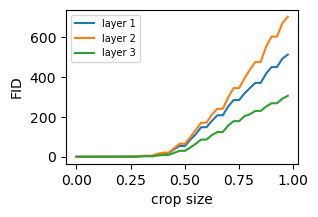

In [39]:
import numpy as np
from fid import distorted_NIST_fid

fid_1 = distorted_NIST_fid(model, name='MNIST', distortion='crop', values=np.arange(0, 1, 0.025), layer='fc1')
fid_2 = distorted_NIST_fid(model, name='MNIST', distortion='crop', values=np.arange(0, 1, 0.025), layer='fc2')
fid_3 = distorted_NIST_fid(model, name='MNIST', distortion='crop', values=np.arange(0, 1, 0.025), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid_1.keys(), fid_1.values(), label='layer 1')
plt.plot(fid_2.keys(), fid_2.values(), label='layer 2')
plt.plot(fid_3.keys(), fid_3.values(), label='layer 3')
plt.ylabel('FID')
plt.xlabel('crop size')
plt.legend(loc='upper left', fontsize=7)
plt.show()